## MetPy Implementation Project

### Issue #434

David PeQueen<br>Aaron Lynn

ATMO 5321<br>Cloud and Precipitation Physics<br>
December 2020



In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

** Note that the functions defined in this notebook are copied here for the user's reference. The functions used by the code in this notebook to create the plots are those in the thermo.py file.

### Current Issue

Add reversible saturated adiabatic paths #434<br>
jrleeman opened this issue on May 25, 2017

"We would like to have reversible processes as well as pseudo adiabatic processes. A few references:

1. <a href="https://glossary.ametsoc.org/wiki/Reversible_moist-adiabatic_process" target="_blank">reversible moist-adiabatic process</a><br>
2. <a href="https://glossary.ametsoc.org/wiki/Moist-adiabatic_lapse_rate" target="_blank">moist-adiabatic lapse rate</a><br>
3. <a href="https://glossary.ametsoc.org/wiki/Pseudoadiabatic_lapse_rate" target="_blank">pseudoadiabatic lapse rate</a>

Upon looking into our current implementation of `moist_lapse` it appears to come from (2) above.
Given that our docs say it's pseudo adiabatic, I would have expected an implementation of (3) (@dopplershift?).
I'm unclear on the difference between the two actually, but it looks like it can make up to 0.7 deg C
difference for a 25 deg C surface parcel lifted to 100 hPa.

Implementing (1) requires some mixing ratios that we do not yet have #433" (https://github.com/Unidata/MetPy/issues/433)

### Equations Referenced in Current Issue

1. <a href="https://glossary.ametsoc.org/wiki/Reversible_moist-adiabatic_process" target="_blank">reversible moist-adiabatic process</a>
\begin{align}
\Gamma_{rm} = g \frac{(1 + r_t)(1 + \frac{L_v r_v}{RT})}{c_{pd} + r_v c_{pv} + r_l c + \frac{L_v^{2} r_v ( \epsilon + r_v)}{R T^{2}}}
\end{align}

> where $\Gamma_{rm}$ is the reversible moist-adiabatic lapse rate; $g$ is gravitational acceleration; $r_v$ is the mixing ratio of water vapor; $r_l$ is the mixing ratio of liquid water; $r_t$ is the mixing ratio of total water; $c_{pd}$, $c_{pv}$, and $c$ are the specific heats at constant pressure of dry air, water vapor, and liquid water; $L_v$ is the latent heat of vaporization; $R$ is the dry air gas constant; $\epsilon$ is the ratio of gas constants between dry air and water vapor; $T$ is temperature.



2. <a href="https://glossary.ametsoc.org/wiki/Moist-adiabatic_lapse_rate" target="_blank">moist-adiabatic lapse rate</a>
\begin{align}
\Gamma_{m} = g \frac{1 + \frac{L_v r_v}{RT}}{c_{pd} + \frac{L_v^{2} r_v \epsilon}{R T^{2}}}
\end{align}

> where $\Gamma_{m}$ is the moist-adiabatic lapse rate; $g$ is gravitational acceleration; $r_v$ is the mixing ratio of water vapor; $c_{pd}$ is the specific heat at constant pressure of dry air; $L_v$ is the latent heat of vaporization; $R$ is the dry air gas constant; $\epsilon$ is the ratio of gas constants between dry air and water vapor; $T$ is temperature.



3. <a href="https://glossary.ametsoc.org/wiki/Pseudoadiabatic_lapse_rate" target="_blank">pseudoadiabatic lapse rate</a>
\begin{align}
\Gamma_{ps} = g \frac{(1 + r_v)(1 + \frac{L_v r_v}{RT})}{c_{pd} + r_v c_{pv} + \frac{L_v^{2} r_v ( \epsilon + r_v)}{R T^{2}}}
\end{align}


> where $\Gamma_{ps}$ is the pseudoadiabatic lapse rate; $g$ is gravitational acceleration; $r_v$ is the mixing ratio of water vapor; $c_{pd}$ and $c_{pv}$ are the specific heats at constant pressure of dry air and water vapor; $L_v$ is the latent heat of vaporization; $R$ is the dry air gas constant; $\epsilon$ is the ratio of gas constants between dry air and water vapor; $T$ is temperature.<br><br>
> The AMS Glossary entry states this lapse rate is "usually within 1 percent of those shown under moist-adiabatic lapse rate and reversible moist-adiabatic lapse rate."


<br>Pseudoadiabatic processes (Equation 3) are irreversible because the liquid water that condenses is assumed to be removed as soon as it is formed by idealized instantaneous precipitation (source: https://glossary.ametsoc.org/wiki/Pseudoadiabatic_process ). The parcel described by the reversible moist-adiabatic process given above (Equation 1) retains all of the condensate, meaning all liquid water content remains with the parcel. The moist-adiabatic lapse rate (Equation 2) follows an isopleth of equivalent potential temperature on a thermodynamic diagram (source: https://glossary.ametsoc.org/wiki/Moist_adiabat ) and is "an approximation to both the reversible moist adiabatic lapse rate and the pseudoadiabatic lapse rate." 

### Current Implementation

In [2]:
# @exporter.export
# @preprocess_xarray
# @check_units('[pressure]', '[temperature]', '[pressure]')
def moist_lapse(pressure, temperature, reference_pressure=None):
    r"""Calculate the temperature at a level assuming liquid saturation processes.

    This function lifts a parcel starting at `temperature`. The starting pressure can
    be given by `reference_pressure`. Essentially, this function is calculating moist
    pseudo-adiabats.

    Parameters
    ----------
    pressure : `pint.Quantity`
        The atmospheric pressure level(s) of interest
    temperature : `pint.Quantity`
        The starting temperature
    reference_pressure : `pint.Quantity`, optional
        The reference pressure. If not given, it defaults to the first element of the
        pressure array.

    Returns
    -------
    `pint.Quantity`
       The resulting parcel temperature at levels given by `pressure`

    See Also
    --------
    dry_lapse : Calculate parcel temperature assuming dry adiabatic processes
    parcel_profile : Calculate complete parcel profile

    Notes
    -----
    This function is implemented by integrating the following differential
    equation:

    .. math:: \frac{dT}{dP} = \frac{1}{P} \frac{R_d T + L_v r_s}
                                {C_{pd} + \frac{L_v^2 r_s \epsilon}{R_d T^2}}

    This equation comes from [Bakhshaii2013]_.

    Only reliably functions on 1D profiles (not higher-dimension vertical cross sections or
    grids).

    """
    def dt(t, p):
        t = units.Quantity(t, temperature.units)
        p = units.Quantity(p, pressure.units)
        rs = saturation_mixing_ratio(p, t)
        frac = ((mpconsts.Rd * t + mpconsts.Lv * rs)
                / (mpconsts.Cp_d + (mpconsts.Lv * mpconsts.Lv * rs * mpconsts.epsilon
                                    / (mpconsts.Rd * t * t)))).to('kelvin')
        return (frac / p).magnitude

    if reference_pressure is None:
        reference_pressure = pressure[0]

    pressure = pressure.to('mbar')
    reference_pressure = reference_pressure.to('mbar')
    temperature = np.atleast_1d(temperature)

    side = 'left'

    pres_decreasing = (pressure[0] > pressure[-1])
    if pres_decreasing:
        # Everything is easier if pressures are in increasing order
        pressure = pressure[::-1]
        side = 'right'

    ref_pres_idx = np.searchsorted(pressure.m, reference_pressure.m, side=side)

    ret_temperatures = np.empty((0, temperature.shape[0]))

    if reference_pressure > pressure.min():
        # Integrate downward in pressure
        pres_down = np.append(reference_pressure.m, pressure[(ref_pres_idx - 1)::-1].m)
        trace_down = si.odeint(dt, temperature.m.squeeze(), pres_down.squeeze())
        ret_temperatures = np.concatenate((ret_temperatures, trace_down[:0:-1]))

    if reference_pressure < pressure.max():
        # Integrate upward in pressure
        pres_up = np.append(reference_pressure.m, pressure[ref_pres_idx:].m)
        trace_up = si.odeint(dt, temperature.m.squeeze(), pres_up.squeeze())
        ret_temperatures = np.concatenate((ret_temperatures, trace_up[1:]))

    if pres_decreasing:
        ret_temperatures = ret_temperatures[::-1]

    return units.Quantity(ret_temperatures.T.squeeze(), temperature.units)


In `dt`, we see that the current implementation from Bakhshaii and Stull (2013) [B&S13] is most similar to our moist-adiabatic lapse rate in Equation (2). The numerator appears to have been multiplied by a factor of $RT$ due to it being expressed as a differential equation. We observe that B&S13 Equation (8) contains a dimensionless parameter $b$ that does not appear in the MetPy calculation. $b$ is given in B&S13 Equation (2), referenced from a previous work, Emanuel (1994), as $1 - 0.24r$. This exclusion appears to have been made deliberately, since the paper cites from Bolton (1980) that the water vapor mixing ratio $r$ is usually less than $0.04 kg_{water vapor} kg_{dry air}^{-1}$. This means that $b$ can be assumed to be 1 with an error typically not greater than $ 0.24 * 0.04 = 0.0096 = 0.96$%.


In [3]:
import metpy
from metpy.units import units

# Copied from src/metpy/constants.py
Lv = water_heat_vaporization = units.Quantity(2.501e6, 'm^2 / s^2')  # at 0C
Lv  

2501000.0 <Unit('meter ** 2 / second ** 2')>

In `moist_lapse`, MetPy uses a constant for the latent heat of vaporization, but we know from Kirchoff's Law that $L_v$ varies as a function of temperature. 

### Documentation Update to moist_lapse()


In [4]:
# @exporter.export
# @preprocess_xarray
# @check_units('[pressure]', '[temperature]', '[pressure]')
def moist_lapse(pressure, temperature, reference_pressure=None):
    r"""Calculate the temperature at a level assuming liquid saturation processes.

    This function lifts a parcel starting at `temperature`. The starting pressure can
    be given by `reference_pressure`. Essentially, this function is calculating moist
    pseudo-adiabats.

    Parameters
    ----------
    pressure : `pint.Quantity`
        The atmospheric pressure level(s) of interest
    temperature : `pint.Quantity`
        The starting temperature
    reference_pressure : `pint.Quantity`, optional
        The reference pressure. If not given, it defaults to the first element of the
        pressure array.

    Returns
    -------
    `pint.Quantity`
       The resulting parcel temperature at levels given by `pressure`

    See Also
    --------
    dry_lapse : Calculate parcel temperature assuming dry adiabatic processes
    parcel_profile : Calculate complete parcel profile
    moist_lapse_pseudoadiabatic : Calcualte parcel temperature assuming irreversible, moist pseudoadiabatic processes
    moist_lapse_reversible : Calculate parcel temperature assuming reversible, moist adiabatic processes

    Notes
    -----
    This function is implemented by integrating the following differential
    equation:

    .. math:: \frac{dT}{dP} = \frac{1}{P} \frac{R_d T + L_v r_s}
                                {C_{pd} + \frac{L_v^2 r_s \epsilon}{R_d T^2}}

    This equation comes from [Bakhshaii2013]_. Our implementation assumes the
    dimensionless parameter b to be 1, which for typical values in the atmosphere,
    should introduce no more error than about 1%.

    Only reliably functions on 1D profiles (not higher-dimension vertical cross sections or
    grids).

    """
    def dt(t, p):
        t = units.Quantity(t, temperature.units)
        p = units.Quantity(p, pressure.units)
        rs = saturation_mixing_ratio(p, t)
        frac = ((mpconsts.Rd * t + mpconsts.Lv * rs)
                / (mpconsts.Cp_d + (mpconsts.Lv * mpconsts.Lv * rs * mpconsts.epsilon
                                    / (mpconsts.Rd * t * t)))).to('kelvin')
        return (frac / p).magnitude

    if reference_pressure is None:
        reference_pressure = pressure[0]

    pressure = pressure.to('mbar')
    reference_pressure = reference_pressure.to('mbar')
    temperature = np.atleast_1d(temperature)

    side = 'left'

    pres_decreasing = (pressure[0] > pressure[-1])
    if pres_decreasing:
        # Everything is easier if pressures are in increasing order
        pressure = pressure[::-1]
        side = 'right'

    ref_pres_idx = np.searchsorted(pressure.m, reference_pressure.m, side=side)

    ret_temperatures = np.empty((0, temperature.shape[0]))

    if reference_pressure > pressure.min():
        # Integrate downward in pressure
        pres_down = np.append(reference_pressure.m, pressure[(ref_pres_idx - 1)::-1].m)
        trace_down = si.odeint(dt, temperature.m.squeeze(), pres_down.squeeze())
        ret_temperatures = np.concatenate((ret_temperatures, trace_down[:0:-1]))

    if reference_pressure < pressure.max():
        # Integrate upward in pressure
        pres_up = np.append(reference_pressure.m, pressure[ref_pres_idx:].m)
        trace_up = si.odeint(dt, temperature.m.squeeze(), pres_up.squeeze())
        ret_temperatures = np.concatenate((ret_temperatures, trace_up[1:]))

    if pres_decreasing:
        ret_temperatures = ret_temperatures[::-1]

    return units.Quantity(ret_temperatures.T.squeeze(), temperature.units)


### New Functions moist_lapse_pseudoadiabatic() and moist_lapse_reversible()

Includes documentation updates.


In [5]:
# @exporter.export
# @preprocess_xarray
# @check_units('[pressure]', '[temperature]', '[pressure]')
def moist_lapse_pseudoadiabatic(pressure, temperature, reference_pressure=None):
    r"""Calculate the temperature at a level assuming an irreversible liquid
    saturation processes, meaning that the liquid water that condenses is removed
    as soon as it is formed, by idealized instantaneous precipitation.
.
    This function lifts a parcel starting at `temperature`. The starting pressure can
    be given by `reference_pressure`. Essentially, this function is calculating moist
    pseudo-adiabats.

    Parameters
    ----------
    pressure : `pint.Quantity`
        The atmospheric pressure level(s) of interest
    temperature : `pint.Quantity`
        The starting temperature
    reference_pressure : `pint.Quantity`, optional
        The reference pressure. If not given, it defaults to the first element of the
        pressure array.

    Returns
    -------
    `pint.Quantity`
       The resulting parcel temperature at levels given by `pressure`

    See Also
    --------
    dry_lapse : Calculate parcel temperature assuming dry adiabatic processes
    parcel_profile : Calculate complete parcel profile
    moist_lapse: Calculate parcel temperature approximating both reversible and irreversible moist adiabatic processes
    moist_lapse_reversible : Calculate parcel temperature assuming reversible, moist adiabatic processes

    Notes
    -----
    This function is implemented by integrating the following differential
    equation:

    .. math:: \frac{dT}{dP} = \frac{1}{P} \frac{(1 + r_s)(R_d T + L_v r_s)}
                                {C_{pd} + r_s c_{pv} + \frac{L_v^2 r_s ( \epsilon + r_s)}{R_d T^2}}

    This equation comes from combining [Bakhshaii2013]_ and the AMS glossary definition given at
    https://glossary.ametsoc.org/wiki/Pseudoadiabatic_lapse_rate.
    
    Only reliably functions on 1D profiles (not higher-dimension vertical cross sections or
    grids).

    """
    def dt(t, p):
        t = units.Quantity(t, temperature.units)
        p = units.Quantity(p, pressure.units)
        rs = saturation_mixing_ratio(p, t)
        frac = ( (1 + rs)*(mpconsts.Rd * t + mpconsts.Lv * rs)
                / (mpconsts.Cp_d + rs*mpconsts.Cv_d +  (mpconsts.Lv * mpconsts.Lv * rs * (mpconsts.epsilon + rs)
                                    / (mpconsts.Rd * t * t)))).to('kelvin')
        return (frac / p).magnitude

    if reference_pressure is None:
        reference_pressure = pressure[0]

    pressure = pressure.to('mbar')
    reference_pressure = reference_pressure.to('mbar')
    temperature = np.atleast_1d(temperature)

    side = 'left'

    pres_decreasing = (pressure[0] > pressure[-1])
    if pres_decreasing:
        # Everything is easier if pressures are in increasing order
        pressure = pressure[::-1]
        side = 'right'

    ref_pres_idx = np.searchsorted(pressure.m, reference_pressure.m, side=side)

    ret_temperatures = np.empty((0, temperature.shape[0]))

    if reference_pressure > pressure.min():
        # Integrate downward in pressure
        pres_down = np.append(reference_pressure.m, pressure[(ref_pres_idx - 1)::-1].m)
        trace_down = si.odeint(dt, temperature.m.squeeze(), pres_down.squeeze())
        ret_temperatures = np.concatenate((ret_temperatures, trace_down[:0:-1]))

    if reference_pressure < pressure.max():
        # Integrate upward in pressure
        pres_up = np.append(reference_pressure.m, pressure[ref_pres_idx:].m)
        trace_up = si.odeint(dt, temperature.m.squeeze(), pres_up.squeeze())
        ret_temperatures = np.concatenate((ret_temperatures, trace_up[1:]))

    if pres_decreasing:
        ret_temperatures = ret_temperatures[::-1]

    return units.Quantity(ret_temperatures.T.squeeze(), temperature.units)


In [6]:
# @exporter.export
# @preprocess_xarray
# @check_units('[pressure]', '[temperature]', '[density]', '[pressure]')
def moist_lapse_reversible(pressure, temperature, rl_LWC, reference_pressure=None):
    r"""Calculate the temperature at a level assuming a reversible liquid
    saturation processes, meaning that all liquid water that condenses
    remains with the parcel.

    This function lifts a parcel starting at `temperature`. The starting pressure can
    be given by `reference_pressure`. Essentially, this function is calculating moist
    pseudo-adiabats.

    Parameters
    ----------
    pressure : `pint.Quantity`
        The atmospheric pressure level(s) of interest
    temperature : `pint.Quantity`
        The starting temperature
    rl_LWC : `pint.Quantity`
        The liquid water content, a constant being used to estimate the liquid water mixing ratio    
    reference_pressure : `pint.Quantity`, optional
        The reference pressure. If not given, it defaults to the first element of the
        pressure array.

    Returns
    -------
    `pint.Quantity`
       The resulting parcel temperature at levels given by `pressure`

    See Also
    --------
    dry_lapse : Calculate parcel temperature assuming dry adiabatic processes
    parcel_profile : Calculate complete parcel profile
    moist_lapse: Calculate parcel temperature approximating both reversible and irreversible moist adiabatic processes
    moist_lapse_pseudoadiabatic : Calcualte parcel temperature assuming irreversible, moist pseudoadiabatic processes

    Notes
    -----
    This function is implemented by integrating the following differential
    equation:

    .. math:: \frac{dT}{dP} = \frac{1}{P} \frac{(1 + r_t)(R_d T + L_v r_s)}
                                {C_{pd} + r_s c_{pv} + r_l c + \frac{L_v^2 r_s ( \epsilon + r_s)}{R_d T^2}}

    This equation comes from combining [Bakhshaii2013]_ and the AMS glossary definition given at
    https://glossary.ametsoc.org/wiki/Reversible_moist-adiabatic_process.

    Only reliably functions on 1D profiles (not higher-dimension vertical cross sections or
    grids).

    """
    def dt(t, p):
        t = units.Quantity(t, temperature.units)
        p = units.Quantity(p, pressure.units)
        rs = saturation_mixing_ratio(p, t)
        rl = rl_LWC * units.Quantity(1/1.225, 'm^3 / kg') * units.Quantity(1/1000,'kg / g')
        rt = rs + rl  ## assuming no ice content
        frac = ( (1 + rt)*(mpconsts.Rd * t + mpconsts.Lv * rs)
                / (mpconsts.Cp_d + rs*mpconsts.Cv_d + rl*mpconsts.Cp_l + (mpconsts.Lv * mpconsts.Lv * rs * (mpconsts.epsilon + rs)
                                    / (mpconsts.Rd * t * t)))).to('kelvin')
        return (frac / p).magnitude

    if reference_pressure is None:
        reference_pressure = pressure[0]

    pressure = pressure.to('mbar')
    reference_pressure = reference_pressure.to('mbar')
    temperature = np.atleast_1d(temperature)

    side = 'left'

    pres_decreasing = (pressure[0] > pressure[-1])
    if pres_decreasing:
        # Everything is easier if pressures are in increasing order
        pressure = pressure[::-1]
        side = 'right'

    ref_pres_idx = np.searchsorted(pressure.m, reference_pressure.m, side=side)

    ret_temperatures = np.empty((0, temperature.shape[0]))

    if reference_pressure > pressure.min():
        # Integrate downward in pressure
        pres_down = np.append(reference_pressure.m, pressure[(ref_pres_idx - 1)::-1].m)
        trace_down = si.odeint(dt, temperature.m.squeeze(), pres_down.squeeze())
        ret_temperatures = np.concatenate((ret_temperatures, trace_down[:0:-1]))

    if reference_pressure < pressure.max():
        # Integrate upward in pressure
        pres_up = np.append(reference_pressure.m, pressure[ref_pres_idx:].m)
        trace_up = si.odeint(dt, temperature.m.squeeze(), pres_up.squeeze())
        ret_temperatures = np.concatenate((ret_temperatures, trace_up[1:]))

    if pres_decreasing:
        ret_temperatures = ret_temperatures[::-1]

    return units.Quantity(ret_temperatures.T.squeeze(), temperature.units)


Note that `moist_lapse_reversible` requires three different mixing ratios: $r_v$, the mixing ratio of water vapor; $r_l$, the mixing ratio of liquid water; $r_t$, the mixing ratio of total water. $r_v$ is the same water vapor mixing ratio already implemented in `moist_lapse`, which is calculated using `saturation_mixing_ratio`. The total water mixing ratio $r_t$ is simply the sum of $r_v$ and $r_l$ if we assume no ice water content in our parcel. This leaves the liquid water mixing ratio $r_l$ as the major area of uncertainty. After a sweep of the literature, we were not able to find a formulation or parameterization for $r_l$ that suited this purpose, at least within the scope of this assignment. A separate <a href="https://github.com/Unidata/MetPy/issues/433" target="_blank">MetPy issue #433 on GitHub</a> asks for both this liquid water mixing ratio and solid water/ice mixing ratios, and it remains open/unresolved.

Different types of clouds have different liquid water contents. Cirrus clouds may have a typical liquid water content (LWC) of 0.03 $g / m^3$ , stratus and cumulus clouds may have typical LCW of 0.25-0.30 $g / m^3$, stratocumulus LWC of 0.45 $g / m^3$, and cumulonimbus may have large LWC ranging from 1.0 $g / m^3$ up to 3.0 $g / m^3$. These types of estimates are obtained from in situ aircraft observations or with multi-wavelength radar techniques. For instance, Hogan et al. (2005) measured LWC in stratocumulus clouds with dual-wavelength radar and compared their data to profiles predicted by simulation. Hogan et al. illustrates the complexity of quantifying the liquid water content in Figure 7, using data from 1997 September 23 in Oklahoma. The plot shows the patchy, non-uniform distribution of LWC on a minute-to-minute basis.

Kalinin and Smirnova (2011) presented LWC profiles of thunderstorm and hail-risk cumulonimbus clouds from 2006 July 17 at Perm at Bol'shoe Savino station in Russia. See the table at the bottom of page 96, as well as the vertical profiles of water content in Figure 3. They found some extreme maximum values, including a reading of 8.60 $g / m^3$ for a hail producing cloud, with a similarly large variance of 3.37. Thunderstorms for their case study averaged LWC of 1.06 $g / m^3$ and hail-producing clouds averaged 3.61 $g / m^3$, with median 2.86 $g / m^3$.

In [7]:
import metpy
from metpy.units import units
import metpy.calc as mpcalc
import numpy as np

# assumes saturated surface parcel
startTemp = 25 * units.degC  
startPressure = 920*units.mbar 
finalPressure = np.arange(100,920,10)*units.mbar

finalTemp_ML_EQ2 = mpcalc.moist_lapse(finalPressure, startTemp, startPressure)
# finalTemp_ML_EQ2

In [8]:
finalTemp_ML_EQ3 = mpcalc.moist_lapse_pseudoadiabatic(finalPressure, startTemp, startPressure)
# finalTemp_ML_EQ3


In [9]:
rl_LWC = units.Quantity(0.3, 'g / m^3')  # typical value for stratus clouds
finalTemp_ML_EQ1 = mpcalc.moist_lapse_reversible(finalPressure, startTemp, rl_LWC, startPressure)
# finalTemp_ML_EQ1


<AxesSubplot:title={'center':'25 deg C Surface Parcel Lifted to 100 hPa'}, xlabel='Temperature [degrees Celcius]', ylabel='Pressure [mb]'>

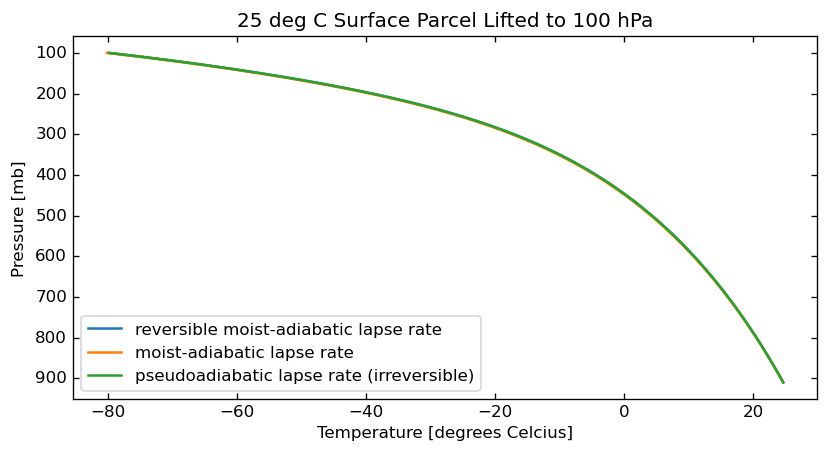

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.axisartist import Subplot

fig = plt.figure(dpi=120,figsize=(8,4))

ax = Subplot(fig, 1, 1, 1)

ax.plot(finalTemp_ML_EQ1, finalPressure)
ax.plot(finalTemp_ML_EQ2, finalPressure)
ax.plot(finalTemp_ML_EQ3, finalPressure)

ax.set_title('25 deg C Surface Parcel Lifted to 100 hPa')
ax.set_xlabel('Temperature [degrees Celcius]')
ax.set_ylabel('Pressure [mb]')
ax.invert_yaxis()
ax.legend(['reversible moist-adiabatic lapse rate','moist-adiabatic lapse rate','pseudoadiabatic lapse rate (irreversible)'])
fig.add_subplot(ax)

# fig.savefig('rl_LWC_{}_plot01.png'.format(rl_LWC))


<AxesSubplot:title={'center':'25 deg C Surface Parcel Lifted to 100 hPa'}, xlabel='Temperature [degrees Celcius]', ylabel='Pressure [mb]'>

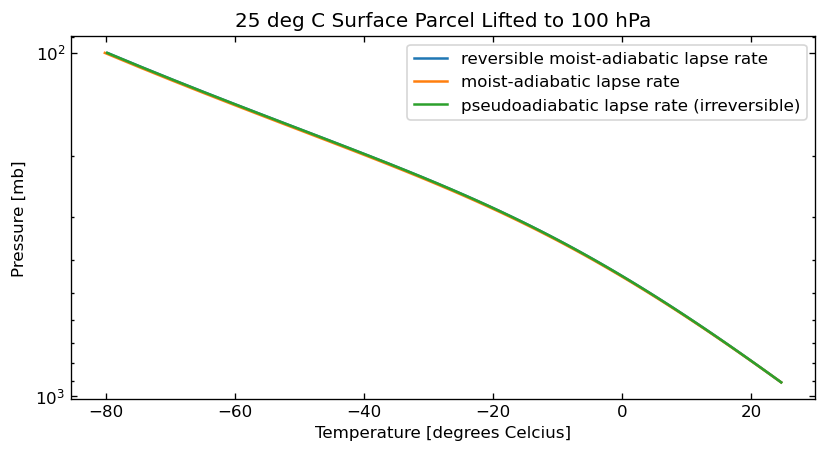

In [11]:
fig = plt.figure(dpi=120,figsize=(8,4))

ax = Subplot(fig, 1, 1, 1)
ax.semilogy(finalTemp_ML_EQ1, finalPressure)
ax.semilogy(finalTemp_ML_EQ2, finalPressure)
ax.semilogy(finalTemp_ML_EQ3, finalPressure)

ax.set_title('25 deg C Surface Parcel Lifted to 100 hPa')
ax.set_xlabel('Temperature [degrees Celcius]')
ax.set_ylabel('Pressure [mb]')
ax.invert_yaxis()
ax.legend(['reversible moist-adiabatic lapse rate','moist-adiabatic lapse rate','pseudoadiabatic lapse rate (irreversible)'])
fig.add_subplot(ax)

# fig.savefig('rl_LWC_{}_plot02.png'.format(rl_LWC))


<AxesSubplot:title={'center':'25 deg C Surface Parcel Lifted to 100 hPa'}, xlabel='Temperature [degrees Celcius]', ylabel='Pressure [mb]'>

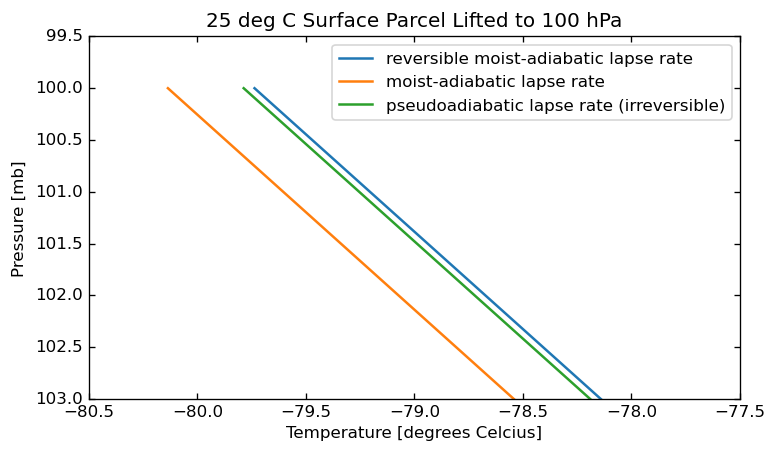

In [12]:
fig = plt.figure(dpi=120,figsize=(7,4))

ax = Subplot(fig, 1, 1, 1)
ax.plot(finalTemp_ML_EQ1, finalPressure)
ax.plot(finalTemp_ML_EQ2, finalPressure)
ax.plot(finalTemp_ML_EQ3, finalPressure)

ax.set_title('25 deg C Surface Parcel Lifted to 100 hPa')
ax.set_xlabel('Temperature [degrees Celcius]')
ax.set_ylabel('Pressure [mb]')
ax.set_xlim([-80.5,-77.5])
ax.set_ylim([99.5,103])
ax.invert_yaxis()
ax.legend(['reversible moist-adiabatic lapse rate','moist-adiabatic lapse rate','pseudoadiabatic lapse rate (irreversible)'])
fig.add_subplot(ax)

# fig.savefig('rl_LWC_{}_plot03.png'.format(rl_LWC))


<AxesSubplot:title={'center':'25 deg C Surface Parcel Lifted to 100 hPa'}, xlabel='Temperature [degrees Celcius]', ylabel='Pressure [mb]'>

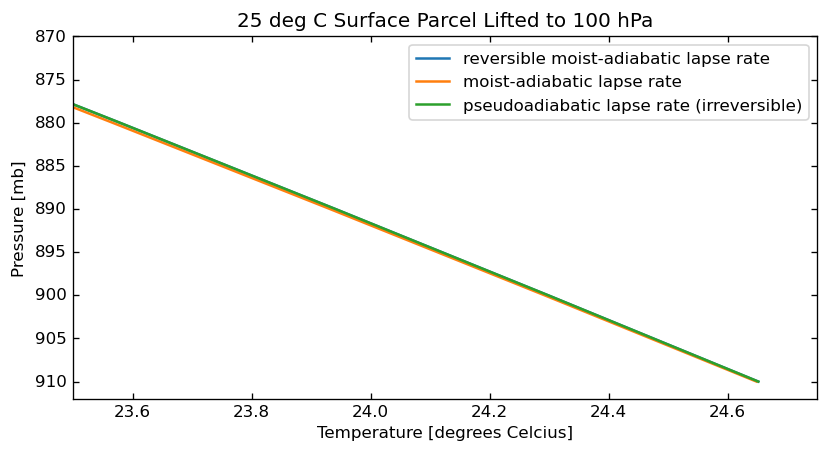

In [13]:
fig = plt.figure(dpi=120,figsize=(8,4))

ax = Subplot(fig, 1, 1, 1)
ax.plot(finalTemp_ML_EQ1, finalPressure)
ax.plot(finalTemp_ML_EQ2, finalPressure)
ax.plot(finalTemp_ML_EQ3, finalPressure)

ax.set_title('25 deg C Surface Parcel Lifted to 100 hPa')
ax.set_xlabel('Temperature [degrees Celcius]')
ax.set_ylabel('Pressure [mb]')
ax.set_xlim([23.5,24.75])
ax.set_ylim([870,912])
ax.invert_yaxis()
ax.legend(['reversible moist-adiabatic lapse rate','moist-adiabatic lapse rate','pseudoadiabatic lapse rate (irreversible)'])
fig.add_subplot(ax)

# fig.savefig('rl_LWC_{}_plot04.png'.format(rl_LWC))


<AxesSubplot:title={'center':'25 deg C Surface Parcel Lifted to 100 hPa: Temperature Difference'}, xlabel='Temperature Difference [degrees Celcius]', ylabel='Pressure [mb]'>

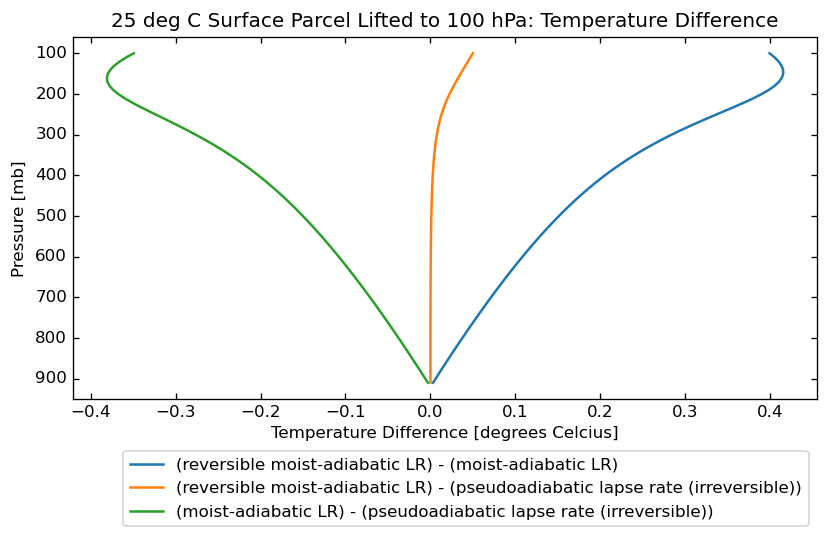

In [14]:
fig = plt.figure(dpi=120,figsize=(8,4))

ax = Subplot(fig, 1, 1, 1)
ax.plot(finalTemp_ML_EQ1-finalTemp_ML_EQ2, finalPressure)
ax.plot(finalTemp_ML_EQ1-finalTemp_ML_EQ3, finalPressure)
ax.plot(finalTemp_ML_EQ2-finalTemp_ML_EQ3, finalPressure)

ax.set_title('25 deg C Surface Parcel Lifted to 100 hPa: Temperature Difference')
ax.set_xlabel('Temperature Difference [degrees Celcius]')
ax.set_ylabel('Pressure [mb]')
ax.invert_yaxis()
ax.legend(['(reversible moist-adiabatic LR) - (moist-adiabatic LR)',
           '(reversible moist-adiabatic LR) - (pseudoadiabatic lapse rate (irreversible))',
           '(moist-adiabatic LR) - (pseudoadiabatic lapse rate (irreversible))'],bbox_to_anchor=(1, -.12))
fig.add_subplot(ax)

# fig.savefig('rl_LWC_{}_plot05.png'.format(rl_LWC))


<AxesSubplot:title={'center':'25 deg C Surface Parcel Lifted to 100 hPa: Temperature Difference due to Lapse Rate (LR)'}, xlabel='Temperature Difference [degrees Celcius]', ylabel='Pressure [mb]'>

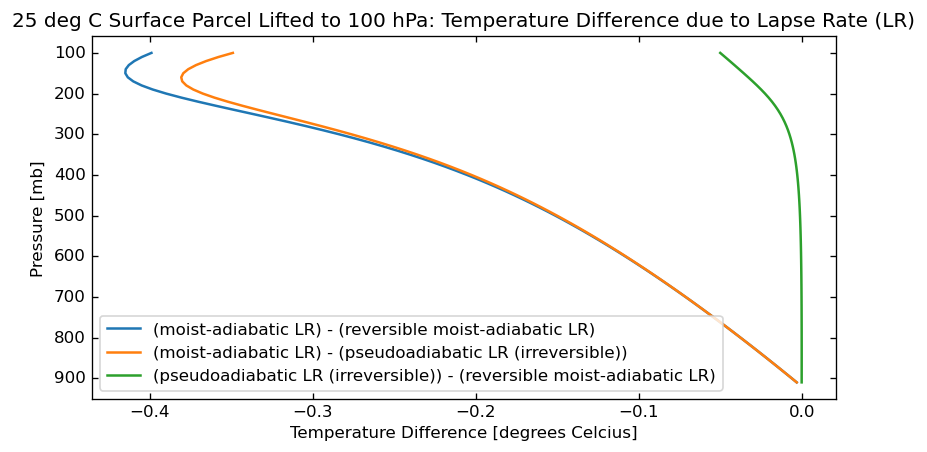

In [15]:
fig = plt.figure(dpi=120,figsize=(8,4))

ax = Subplot(fig, 1, 1, 1)
ax.plot(finalTemp_ML_EQ2-finalTemp_ML_EQ1, finalPressure)
ax.plot(finalTemp_ML_EQ2-finalTemp_ML_EQ3, finalPressure)
ax.plot(finalTemp_ML_EQ3-finalTemp_ML_EQ1, finalPressure)

ax.set_title('25 deg C Surface Parcel Lifted to 100 hPa: Temperature Difference due to Lapse Rate (LR)')
ax.set_xlabel('Temperature Difference [degrees Celcius]')
ax.set_ylabel('Pressure [mb]')
ax.invert_yaxis()
ax.legend(['(moist-adiabatic LR) - (reversible moist-adiabatic LR)',
           '(moist-adiabatic LR) - (pseudoadiabatic LR (irreversible))',
           '(pseudoadiabatic LR (irreversible)) - (reversible moist-adiabatic LR)'])
fig.add_subplot(ax)

# fig.savefig('rl_LWC_{}_plot06.png'.format(rl_LWC))


In [16]:
rl_LWC = units.Quantity(2.5, 'g / m^3')   # typical value for cumulonimbus clouds
finalTemp_ML_EQ1 = mpcalc.moist_lapse_reversible(finalPressure, startTemp, rl_LWC, startPressure)
# finalTemp_ML_EQ1


<AxesSubplot:title={'center':'25 deg C Surface Parcel Lifted to 100 hPa'}, xlabel='Temperature [degrees Celcius]', ylabel='Pressure [mb]'>

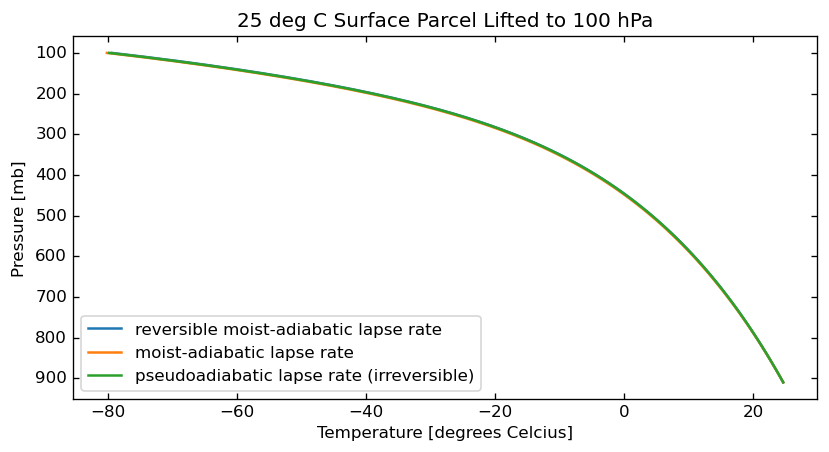

In [17]:
fig = plt.figure(dpi=120,figsize=(8,4))

ax = Subplot(fig, 1, 1, 1)

ax.plot(finalTemp_ML_EQ1, finalPressure)
ax.plot(finalTemp_ML_EQ2, finalPressure)
ax.plot(finalTemp_ML_EQ3, finalPressure)

ax.set_title('25 deg C Surface Parcel Lifted to 100 hPa')
ax.set_xlabel('Temperature [degrees Celcius]')
ax.set_ylabel('Pressure [mb]')
ax.invert_yaxis()
ax.legend(['reversible moist-adiabatic lapse rate','moist-adiabatic lapse rate','pseudoadiabatic lapse rate (irreversible)'])
fig.add_subplot(ax)

# fig.savefig('rl_LWC_{}_plot01.png'.format(rl_LWC))



<AxesSubplot:title={'center':'25 deg C Surface Parcel Lifted to 100 hPa'}, xlabel='Temperature [degrees Celcius]', ylabel='Pressure [mb]'>

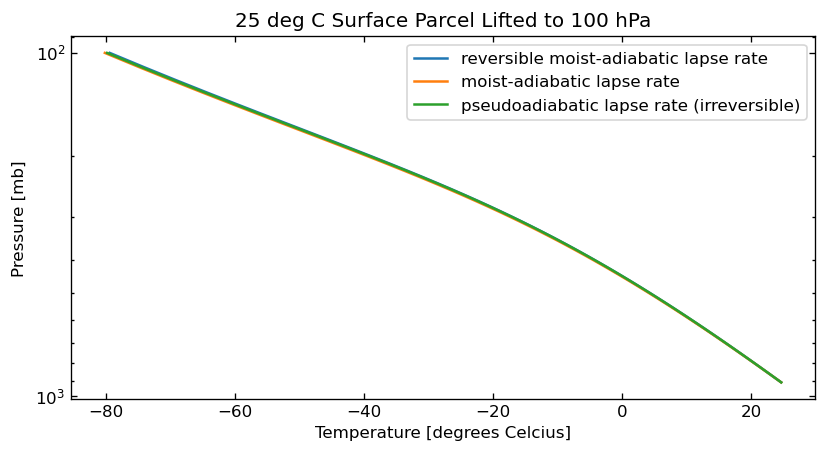

In [18]:
fig = plt.figure(dpi=120,figsize=(8,4))

ax = Subplot(fig, 1, 1, 1)
ax.semilogy(finalTemp_ML_EQ1, finalPressure)
ax.semilogy(finalTemp_ML_EQ2, finalPressure)
ax.semilogy(finalTemp_ML_EQ3, finalPressure)

ax.set_title('25 deg C Surface Parcel Lifted to 100 hPa')
ax.set_xlabel('Temperature [degrees Celcius]')
ax.set_ylabel('Pressure [mb]')
ax.invert_yaxis()
ax.legend(['reversible moist-adiabatic lapse rate','moist-adiabatic lapse rate','pseudoadiabatic lapse rate (irreversible)'])
fig.add_subplot(ax)

# fig.savefig('rl_LWC_{}_plot02.png'.format(rl_LWC))


<AxesSubplot:title={'center':'25 deg C Surface Parcel Lifted to 100 hPa'}, xlabel='Temperature [degrees Celcius]', ylabel='Pressure [mb]'>

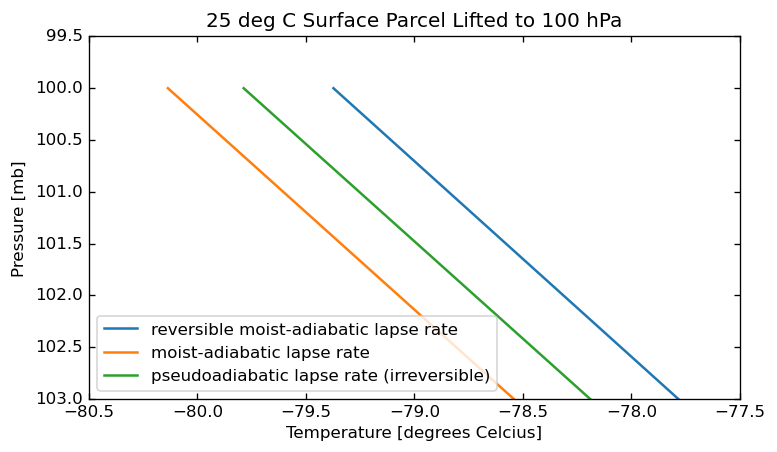

In [19]:
fig = plt.figure(dpi=120,figsize=(7,4))

ax = Subplot(fig, 1, 1, 1)
ax.plot(finalTemp_ML_EQ1, finalPressure)
ax.plot(finalTemp_ML_EQ2, finalPressure)
ax.plot(finalTemp_ML_EQ3, finalPressure)

ax.set_title('25 deg C Surface Parcel Lifted to 100 hPa')
ax.set_xlabel('Temperature [degrees Celcius]')
ax.set_ylabel('Pressure [mb]')
ax.set_xlim([-80.5,-77.5])
ax.set_ylim([99.5,103])
ax.invert_yaxis()
ax.legend(['reversible moist-adiabatic lapse rate','moist-adiabatic lapse rate','pseudoadiabatic lapse rate (irreversible)'])
fig.add_subplot(ax)

# fig.savefig('rl_LWC_{}_plot03.png'.format(rl_LWC))


<AxesSubplot:title={'center':'25 deg C Surface Parcel Lifted to 100 hPa'}, xlabel='Temperature [degrees Celcius]', ylabel='Pressure [mb]'>

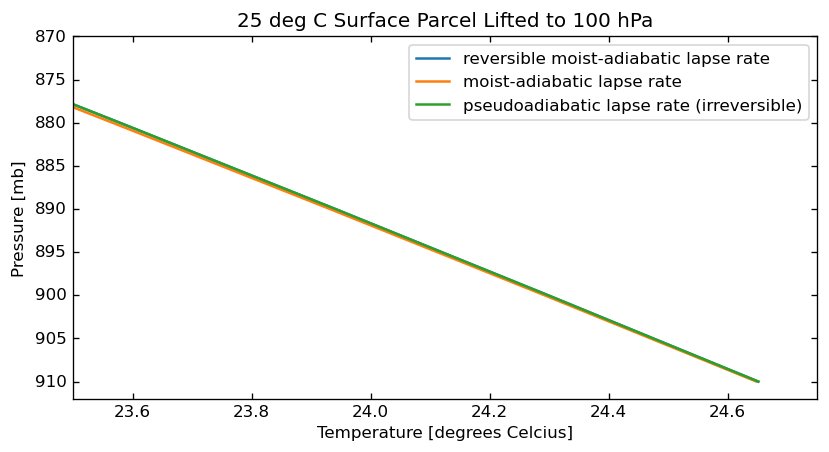

In [20]:
fig = plt.figure(dpi=120,figsize=(8,4))

ax = Subplot(fig, 1, 1, 1)
ax.plot(finalTemp_ML_EQ1, finalPressure)
ax.plot(finalTemp_ML_EQ2, finalPressure)
ax.plot(finalTemp_ML_EQ3, finalPressure)

ax.set_title('25 deg C Surface Parcel Lifted to 100 hPa')
ax.set_xlabel('Temperature [degrees Celcius]')
ax.set_ylabel('Pressure [mb]')
ax.set_xlim([23.5,24.75])
ax.set_ylim([870,912])
ax.invert_yaxis()
ax.legend(['reversible moist-adiabatic lapse rate','moist-adiabatic lapse rate','pseudoadiabatic lapse rate (irreversible)'])
fig.add_subplot(ax)

# fig.savefig('rl_LWC_{}_plot04.png'.format(rl_LWC))


<AxesSubplot:title={'center':'25 deg C Surface Parcel Lifted to 100 hPa: Temperature Difference'}, xlabel='Temperature Difference [degrees Celcius]', ylabel='Pressure [mb]'>

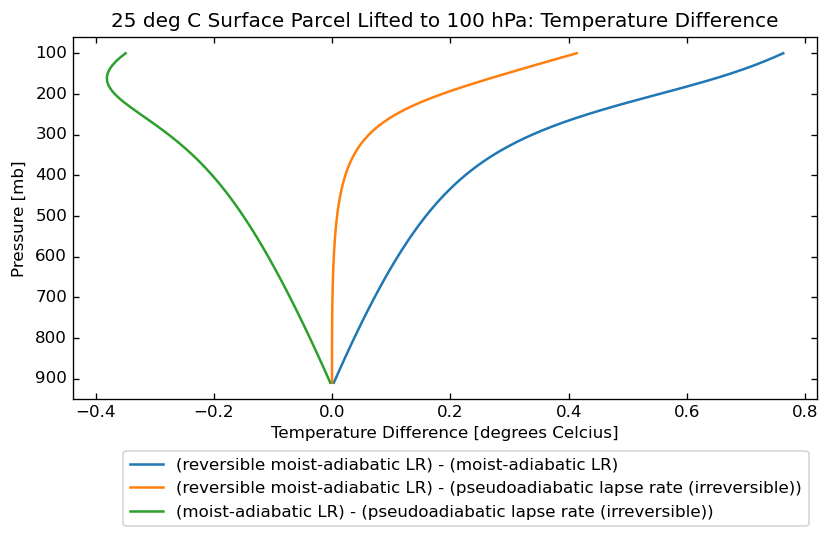

In [21]:
fig = plt.figure(dpi=120,figsize=(8,4))

ax = Subplot(fig, 1, 1, 1)
ax.plot(finalTemp_ML_EQ1-finalTemp_ML_EQ2, finalPressure)
ax.plot(finalTemp_ML_EQ1-finalTemp_ML_EQ3, finalPressure)
ax.plot(finalTemp_ML_EQ2-finalTemp_ML_EQ3, finalPressure)

ax.set_title('25 deg C Surface Parcel Lifted to 100 hPa: Temperature Difference')
ax.set_xlabel('Temperature Difference [degrees Celcius]')
ax.set_ylabel('Pressure [mb]')
ax.invert_yaxis()
ax.legend(['(reversible moist-adiabatic LR) - (moist-adiabatic LR)',
           '(reversible moist-adiabatic LR) - (pseudoadiabatic lapse rate (irreversible))',
           '(moist-adiabatic LR) - (pseudoadiabatic lapse rate (irreversible))'],bbox_to_anchor=(1, -.12))
fig.add_subplot(ax)

# fig.savefig('rl_LWC_{}_plot05.png'.format(rl_LWC))


<AxesSubplot:title={'center':'25 deg C Surface Parcel Lifted to 100 hPa: Temperature Difference due to Lapse Rate (LR)'}, xlabel='Temperature Difference [degrees Celcius]', ylabel='Pressure [mb]'>

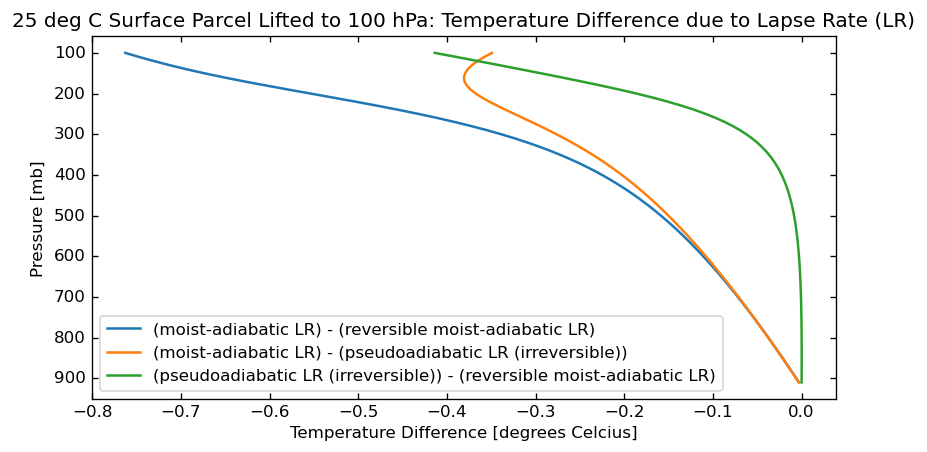

In [22]:
fig = plt.figure(dpi=120,figsize=(8,4))

ax = Subplot(fig, 1, 1, 1)
ax.plot(finalTemp_ML_EQ2-finalTemp_ML_EQ1, finalPressure)
ax.plot(finalTemp_ML_EQ2-finalTemp_ML_EQ3, finalPressure)
ax.plot(finalTemp_ML_EQ3-finalTemp_ML_EQ1, finalPressure)

ax.set_title('25 deg C Surface Parcel Lifted to 100 hPa: Temperature Difference due to Lapse Rate (LR)')
ax.set_xlabel('Temperature Difference [degrees Celcius]')
ax.set_ylabel('Pressure [mb]')
ax.invert_yaxis()
ax.legend(['(moist-adiabatic LR) - (reversible moist-adiabatic LR)',
           '(moist-adiabatic LR) - (pseudoadiabatic LR (irreversible))',
           '(pseudoadiabatic LR (irreversible)) - (reversible moist-adiabatic LR)'])
fig.add_subplot(ax)

# fig.savefig('rl_LWC_{}_plot06.png'.format(rl_LWC))



### References

Bakhshaii, A., and R. Stull, 2013: Saturated pseudoadiabats—A noniterative approximation. $\textit{J. Appl. Meteor. Climatol.}$, 52, 5-15.<br>

Bolton, D., 1980: The computation of equivalent potential temperature. $\textit{Mon. Wea. Rev.}$, 108, 1046–1053.<br>

Emanuel, K. A., 1994: $\textit{Atmospheric Convection}$. Oxford University Press, 580 pp.<br>

Hogan, R. J., Gaussiat, N., and A. J. Illingworth, 2005: Stratocumulus liquid water content from dual-wavelength radar. $\textit{J. Atmos. Oceanic Technol.}$, 22, 8, 1207–1218.<br>

Kalinin, N. A., and A. A. Smirnova, 2011: Determination of liquid water content and reserve of cumulonimbus cloudiness from meteorological radar information. $\textit{Russ. Meteorol. Hydrol.}$, 36, 91–101.

